In [1]:
%matplotlib inline
import numpy as np
import fitsio as ft
import matplotlib.pyplot as plt
from   matplotlib.gridspec import GridSpec

import pandas as pd
import seaborn as sns
import pymangle
import healpy as hp
import sys
sys.path.append('../src')
from scipy.stats import pearsonr
from glob import glob
import plotting
import os
os.environ['PROJ_LIB'] = '/Users/rezaie/anaconda3/envs/py3p6/share/proj'

In [31]:
config = {'hpmap':{'frac':'/Volumes/TimeMachine/data/DR7/frac.hp.256.fits',
                   'ngal':'/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.cut.hp256.fits',
                   'ouname':'./figs/eboss-dr7.png',
                   'title':r'eBOSS ELG DECaLS DR7 density [deg$^{-2}$]',
                   'nside':256},
         'ccplot':{'frac':'/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/fracgood.hp.fits',
                   'ngal':'/Volumes/TimeMachine/data/DR7/eboss-ngc-dr7.1.cut.hp256.fits',
                   'feats':'/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/features.fits',
                  'ouname':'./figs/dr7_ccs.pdf',
                  'xticks':['ebv', 'nstar']+ [s+'-'+b for s in 
                                               ['depth', 'seeing', 'skymag','exptime', 'mjd'] for b in 'rgz'],
                  'label':'DR7 Data'},
          '2dclustering':{'cl_theory':'/Volumes/TimeMachine/data/mocks/fftlog.out',
                         'clpath':lambda l:'/Volumes/TimeMachine/data/DR7/results/clustering/cl_'+l+'.npy',
                         'xipath':lambda l:'/Volumes/TimeMachine/data/DR7/results/clustering/xi_'+l+'.npy',
                         'title':'DR7 DATA',
                          #'lb':['with linear weights','with quadratic weights','no weights', 
                          #        'with NN weights (spatial)','with NN weights', 'with NN weights w/ ablation'],
                          #'flb':['lin', 'quad', 'uni', 'nns-10', 'nnr-10', 'nnrab-10'],
                          'lb':['No Correction', 'Linear','Quadratic', 'Neural Network', 'Neural Network Plain'],
                          'flb':['uni','lin', 'quad', 'nn_ab', 'nn_p'],                          
                         'ouname':'./figs/dr7_clustering.pdf'},
         'corrmax':{'feats':'/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.table.fits',
                     'xticks':['EBV', 'logHI', 'nstar']+ [s+'-'+b for s in 
                               ['depth', 'seeing', 'skymag','exptime', 'mjd'] for b in 'rgz'],
                   'ouname':'./figs/corrmax-dr7.pdf'},
          'nnbarplot':{'nnbarpath':lambda l:'/Volumes/TimeMachine/data/DR7/results/clustering/nnbar_'+l+'.npy',
                         'title':'DR7 DATA',
                          #'lb':['with linear weights','with quadratic weights','no weights', 
                          #       'with NN weights (spatial)','with NN weights', 'with NN weights w/ ablation'],
                          #'flb':['lin', 'quad', 'uni', 'nns-10', 'nnr-10', 'nnrab-10'],
                          'lb':['No Correction', 'Linear','Quadratic', 'Neural Network'],
                          'flb':['uni','lin', 'quad', 'nn_ab'],                          
                         'ouname':'./figs/dr7_nnbar.pdf'},
          'mocks_ablation':{'uncont.':'/Volumes/TimeMachine/data/mocks/3dbox/*/ablation/r/*.log.npy',
                            'cont.':'/Volumes/TimeMachine/data/mocks/3dbox/*/c4n/ablation/r/*.log.npy',
                            'xticks':['ebv', 'nstar']+[s+'-'+b for s in ['depth', 'seeing', 'airmass',
                                                                         'skymag', 'exptime'] for b in 'rgz'],
                           'title':'DR5 Mocks',
                           'ouname':'./figs/mocks_ablation.pdf'},
        'crosscl':{
             'clpath':lambda l:'/Volumes/TimeMachine/data/DR7/results/clustering/cl_'+l+'.npy',
             'clsys':'/Volumes/TimeMachine/data/DR7/results/clustering/cl_sys.npy',
             'xipath':lambda l:'/Volumes/TimeMachine/data/DR7/results/clustering/xi_'+l+'_nside_256_njack_0.npy',
             'title':'DR7 DATA',
              #'lb':['with linear weights','with quadratic weights','no weights', 
              #        'with NN weights (spatial)','with NN weights', 'with NN weights w/ ablation'],
              #'flb':['lin', 'quad', 'uni', 'nns-10', 'nnr-10', 'nnrab-10'],
              'lb':['No Correction', 'Linear','Quadratic', 'Neural Network'],
              'flb':['uni','lin', 'quad', 'nn_ab'],                          
             'ouname':'./figs/dr7_crosscl.pdf',
              'xticks':['ebv', 'lnHI', 'nstar']+ [s+'-'+b for s in 
                       ['depth', 'seeing', 'skymag','exptime', 'mjd'] for b in 'rgz']},
        'crossxi':{
             'clpath':lambda l:'/Volumes/TimeMachine/data/DR7/results/clustering/cl_'+l+'.npy',
             'clsys':'/Volumes/TimeMachine/data/DR7/results/clustering/cl_sys.npy',
             'xipath':lambda l:'/Volumes/TimeMachine/data/DR7/results/clustering/xi_'+l+'.npy',
              'xisys':'/Volumes/TimeMachine/data/DR7/results/clustering/xi_sys.npy',
             'title':'DR7 DATA',
              #'lb':['with linear weights','with quadratic weights','no weights', 
              #        'with NN weights (spatial)','with NN weights', 'with NN weights w/ ablation'],
              #'flb':['lin', 'quad', 'uni', 'nns-10', 'nnr-10', 'nnrab-10'],
              'lb':['No Correction', 'Linear','Quadratic', 'Neural Network'],
              'flb':['uni','lin', 'quad', 'nn_ab'],                          
             'ouname':'./figs/dr7_crossxi.pdf',
              'xticks':['ebv', 'lnHI', 'nstar']+ [s+'-'+b for s in 
                       ['depth', 'seeing', 'skymag','exptime', 'mjd'] for b in 'rgz']}          
         }

Multipoles HEALPIX

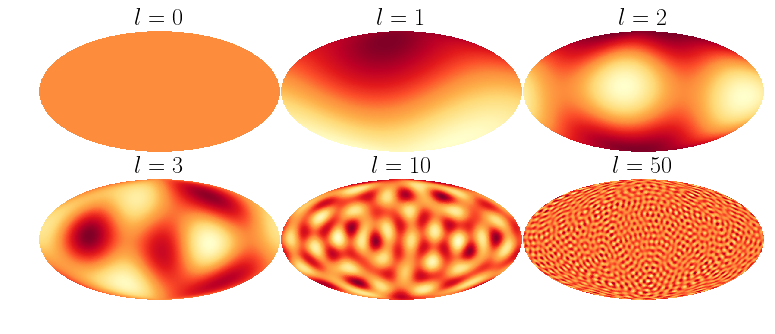

In [86]:
def plot_multipoles():
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'text.usetex': True,
   #'figure.figsize': [6, 4],
   'font.family':'serif',
    'font.size':20
   }
    cmap = plt.cm.YlOrRd_r
    cmap.set_under('w')
    plt.rcParams.update(params)
#     plt.rc('font', family='serif', size=15)
    np.random.seed(12345)
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(13, 5))
    plt.subplots_adjust(wspace=0., hspace=0.2)
    ax      = ax.flatten()
    for il,l in enumerate([0, 1, 2, 3, 10, 50]):    
        cl    = np.zeros(12*128*128)
        cl[l] = 1
        map1  = hp.synfast(cl, 128, pol=False, new=True, verbose=False)
        plt.sca(ax[il])
        hp.mollview(map1, cbar=False, notext=True, title=r'$l=%d$'%l, hold=True, cmap=cmap) #cmap.set_under('w')
    plt.savefig('./figs/multipoles.pdf', bbox_inches='tight')
plot_multipoles()

## Correlation matrix of DR7 metadata

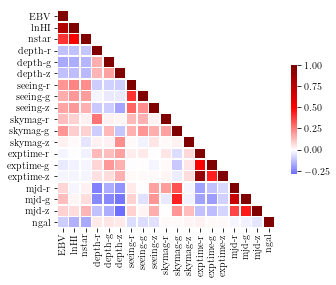

In [47]:
def plot_corrmax(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 12,
   #'text.fontsize': 8,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': True,
   #'figure.figsize': [6, 4],
   'font.family':'serif'
   }
    plt.rcParams.update(params)
    data, h = ft.read(config['corrmax']['feats'], header=True)
    labels = config['corrmax']['xticks']
    labels[1] = 'lnHI'  # log to ln
    mat = np.column_stack([data['features'].byteswap().newbyteorder(),
                           data['label'].byteswap().newbyteorder()])
    d = pd.DataFrame(data=mat, columns=labels+['ngal'])
    corr_cf = d.corr()
    mask = np.ones_like(corr_cf, dtype=np.bool)
    mask[np.tril_indices_from(mask)] = False
    f, ax = plt.subplots(figsize=(6, 4))
    kw = dict(mask=mask, cmap=plt.cm.seismic, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    sns.heatmap(corr_cf, **kw)
    plt.savefig(config['corrmax']['ouname'], bbox_inches='tight')
plot_corrmax(config)

## DR7 eBOSS-like ELG Density map

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


358.6341092318108


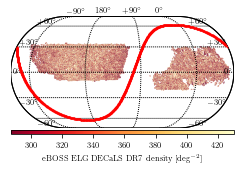

In [46]:
# density map
def plot_elghmap(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 8,
   #'text.fontsize': 8,
   'legend.fontsize': 8,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':8
   }
    plt.rcParams.update(params)    
    frac = hp.read_map(config['hpmap']['frac'], verbose=False)
    ngal = hp.read_map(config['hpmap']['ngal'], verbose=False)
    #plt.rc('font', family='serif', size=15)
    plt.figure(figsize=(4, 3))
    hmap = ngal/frac/hp.nside2pixarea(config['hpmap']['nside'], degrees=True)
    hm   = np.mean(hmap[(hmap!=0.0) & ~np.isnan(hmap) & ~np.isinf(hmap)])
    print(hm)
    plotting.plot_healpix_map(hmap, 
                              label=config['hpmap']['title'],
                              vlimits=[0.8*hm, 1.2*hm], cmap='YlOrRd_r')
    plt.savefig(config['hpmap']['ouname'], bbox_inches='tight', dpi=300)
    
# plot density map    
plot_elghmap(config)

0.30985871034917145


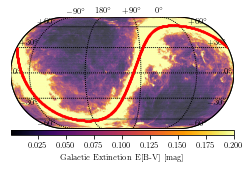

In [16]:
# density map
def plot_elghmap(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 8,
   #'text.fontsize': 8,
   'legend.fontsize': 8,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':8
   }
    plt.rcParams.update(params)    
    #frac = hp.read_map(config['hpmap']['frac'], verbose=False)
    hmap = hp.read_map('/Volumes/TimeMachine/data/healSFD_256_fullsky.fits', verbose=False)
    #plt.rc('font', family='serif', size=15)
    plt.figure(figsize=(4, 3))
    hm   = np.mean(hmap[(hmap!=0.0) & ~np.isnan(hmap) & ~np.isinf(hmap)])
    print(hm)
    plotting.plot_healpix_map(hmap, 
                              label='Galactic Extinction E[B-V] [mag]',
                              vlimits=[None, 0.2], cmap='inferno')
    plt.savefig('./figs/ebv_fullsky.png', bbox_inches='tight', dpi=300)
    
# plot density map    
plot_elghmap(config)

## Ablation


86.5291664538903 -1.481598392665262
save ...  ./figs/dr7.pdf


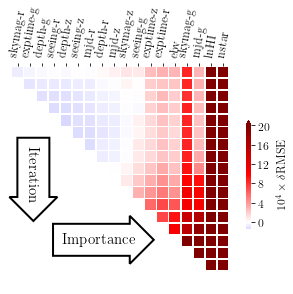

In [99]:
def ablation_plot(filename, odir):    
    params = {
    'axes.spines.right':False,
    'axes.spines.top':False,
    'axes.labelsize': 12,
    #'text.fontsize': 8,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'figure.figsize': [6, 4], # 11 9
    'font.family':'serif'}
    plt.rcParams.update(params)
    ab1 = np.load(filename).item()
    #
    INDICES = ab1['indices']
    VALUES  = ab1['validmin']
    FEAT    = ab1['importance'] + [i for i in range(18)\
                  if i not in ab1['importance']]

    matric_dict = {}
    for i in range(len(INDICES)):
        for j in range(len(VALUES[i])):
            matric_dict[str(i)+'-'+str(INDICES[i][j])] = VALUES[i][j]

    matric = np.zeros(shape=(18, 18))
    for i in range(17):
        for j, sys_i in enumerate(FEAT):
            if str(i)+'-'+str(sys_i) in matric_dict.keys():
                matric[i,j] = (matric_dict['%d-%d'%(i,sys_i)][0]/ab1['RMSEall'])-1.#-ab1['baselineRMSE']
    matric *= 1.e4
    bands = ['r','g','z']
    labels = ['ebv','lnHI','nstar']
    labels += ['depth-'+b for b in bands]
    labels += ['seeing-'+b for b in bands]
    #labels += ['airmass-'+b for b in bands]
    labels += ['skymag-'+b for b in bands]
    labels += ['exptime-'+b for b in bands]
    labels += ['mjd-'+b for b in bands]
    xlabels = [labels[j] for j in FEAT]
    mask = ~np.zeros_like(matric, dtype=np.bool)
    #mask[np.triu_indices_from(mask)] = False
    mask[matric==0.0] = False
    vmin = np.minimum(np.abs(np.min(matric)), np.abs(np.max(matric))) #* 0.1
    print(np.max(matric), np.min(matric))
    # Set up the matplotlib figure
    f, ax = plt.subplots()
    #plt.title('Correlation Matrix of DR5')
    # Generate a custom diverging colormap
    kw = dict(mask=~mask, cmap=plt.cm.seismic, xticklabels=xlabels, #PRGn_r,get_cmap('PRGn_r', 20)
               yticklabels=xlabels[::-1], 
               vmax=20, center=0.0,#vmin=-1.*vmin, vmax=vmin, center=0.0,
               square=True, linewidths=.5, 
               cbar_kws={"shrink": .5, 
               "label":r'$10^{4} \times \delta$RMSE', "extend":"max"})
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(matric, **kw)
    ax.set_xticklabels(xlabels, rotation=80)
    ax.set_yticks([])
    ax.xaxis.tick_top()
    bbox_props = dict(boxstyle="rarrow", fc="white", ec="k", lw=2)
    t = ax.text(0.4, 0.2, "Importance",
                ha="center", va="center", rotation=0,
                transform=ax.transAxes,
                bbox=bbox_props, fontsize=15)
    bb = t.get_bbox_patch()
    bb.set_boxstyle("rarrow", pad=0.6)
    t1 = ax.text(0.1, 0.5, "Iteration",
                ha="center", va="center", rotation=-90,
                transform=ax.transAxes,
                bbox=bbox_props, fontsize=15)
    bb1 = t1.get_bbox_patch()
    bb1.set_boxstyle("rarrow", pad=0.6)
    fname = filename.split('/')[-1][:-8]  # drop .log.npy
    #ou = ''.join([filename[:-4], '.pdf']) # drop .npy
    ou = ''.join([odir, fname, '.pdf'])
    print('save ... ', ou)
    plt.savefig(ou, bbox_inches='tight')


ablation_plot('/Volumes/TimeMachine/data/DR7/results/ablation/dr7.log.npy','./figs/')

## Selection masks

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


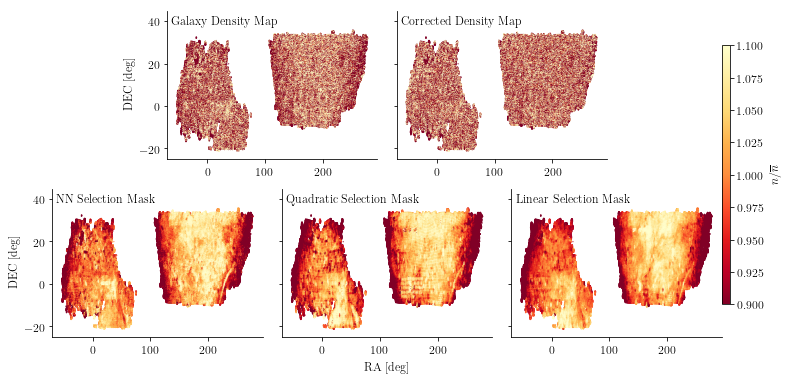

In [4]:
def ngal_selection_masks():   
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 12,
   #'text.fontsize': 8,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
   'font.size':12
   }
    plt.rcParams.update(params)        
    from utils import makedelta, hpix2radec
    galmap = hp.read_map('/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.cut.hp256.fits', verbose=False)
    wnn    = hp.read_map('/Volumes/TimeMachine/data/DR7/results/regression/nn_ab/nn-weights.hp256.fits', verbose=False)
    wlin   = hp.read_map('/Volumes/TimeMachine/data/DR7/results/regression/mult_all/lin-weights.hp256.fits', verbose=False)
    wqud   = hp.read_map('/Volumes/TimeMachine/data/DR7/results/regression/mult_all/quad-weights.hp256.fits', verbose=False)
    mask   = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.hp.256.fits', verbose=False).astype('bool')
    frac   = hp.read_map('/Volumes/TimeMachine/data/DR7/frac.hp.256.fits', verbose=False)
    # smooth the NN weights
    #wnnmean = np.mean(wnn[mask])
    #print(wnnmean)
    #wnn[~mask] = wnnmean
    #print(np.mean(galmap[mask]))
    #sdeg = np.deg2rad(0.25)
    #wnn = hp.smoothing(wnn.copy(), sigma=sdeg)
    #
    dnn   = makedelta(galmap, frac, mask, wnn) + 1.0
    # dlin = makedelta(galmap, frac, mask, wlin)
    # duni = makedelta(galmap, frac, mask)
    nnbar = makedelta(galmap, frac, mask) + 1.0

    plt.rc('axes.spines', top=False, right=False)
    plt.rc('font', family='serif')
    plt.rc('text', usetex=True)
    hpix = np.argwhere(mask).flatten()
    #fig, ax = plt.subplots(nrows=5, figsize=(4, 15), sharex=True)
    #plt.subplots_adjust(hspace=0.05)
    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(2, 6, figure=fig)
    gs.update(wspace=0.2, hspace=0.2)
    ax1 = plt.subplot(gs[0, 1:3])
    ax2 = plt.subplot(gs[0, 3:5])
    ax3 = plt.subplot(gs[1, 0:2])
    ax4 = plt.subplot(gs[1, 2:4])
    ax5 = plt.subplot(gs[1, 4:6])
    for ax in [ax2, ax4, ax5]:
        ax.tick_params(labelleft=False)
    ax = [ax1, ax2, ax3, ax4, ax5]
    
    #ttl = ['No weights', 'Linear weights', 'NN weights']
    ttl = ['Galaxy Density Map', 'Corrected Density Map', 
           'NN Selection Mask', 'Quadratic Selection Mask', 
           'Linear Selection Mask']
    
    #for i,di in enumerate([duni, dlin, dnn]):
    radec = hpix2radec(256, hpix)
    ramm  = radec[0] > 300
    radec[0][ramm] -= 360.    
    for i,di in enumerate([nnbar, dnn, wnn, wqud, wlin]):
        map1 = ax[i].scatter(radec[0], radec[1], 0.1, 
                             #c=5*di[mask], vmin=-1, vmax=1.,
                            c=di[mask], vmin=0.9, vmax=1.1,
                            cmap=plt.cm.YlOrRd_r)
        ax[i].text(0.02, 0.9, ttl[i], transform=ax[i].transAxes)
        ax[i].set_ylim(-25, 45)
        ax[3].set_xlabel('RA [deg]')
        if i in [0, 2]:ax[i].set_ylabel('DEC [deg]')
        #ax[i].axis([200, 310, 0, 20])
    cax = plt.axes([.9, 0.2, 0.01, 0.6])
    #fig.colorbar(map1, cax=cax)
    fig.colorbar(map1, cax=cax, label=r'$n/\overline{n}$', shrink=0.7)
    plt.savefig('./figs/deltas.png', bbox_inches='tight', dpi=300)
ngal_selection_masks()

camb is not installed!


/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


-0.8938297862230515 7.005466238938037
-0.17907491193096892 1.658631353936358
-0.10337270229297879 1.4132270173432537
0.0047528263295898154


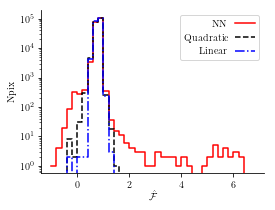

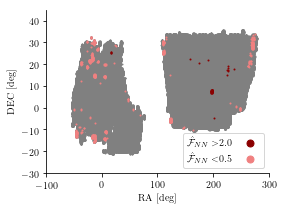

In [57]:
def selection_masks_hists():
    from utils import makedelta, hpix2radec
    params = {
    'axes.spines.right':False,
    'axes.spines.top':False,
    'axes.labelsize': 10,
    #'text.fontsize': 8,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': True,
    'figure.figsize': [4, 3],
    'font.family':'serif',
    'font.size':10
    }
    plt.rcParams.update(params)            
    wnn    = hp.read_map('/Volumes/TimeMachine/data/DR7/results/regression/nn_ab/nn-weights.hp256.fits',
                         verbose=False)
    wlin   = hp.read_map('/Volumes/TimeMachine/data/DR7/results/regression/mult_all/lin-weights.hp256.fits',
                         verbose=False)
    wqud   = hp.read_map('/Volumes/TimeMachine/data/DR7/results/regression/mult_all/quad-weights.hp256.fits',
                         verbose=False)
    mask   = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.hp.256.fits', 
                         verbose=False).astype('bool')
    frac   = hp.read_map('/Volumes/TimeMachine/data/DR7/frac.hp.256.fits',
                         verbose=False)    
    #
    #
    h = ['.', None, None]
    lb= ['NN', 'Quadratic', 'Linear'] 
    cl=['r', 'k', 'blue']
    ls=['-', '--', '-.']
    i = 0
    plt.figure()
    for sm in [wnn, wqud, wlin]:
        print(sm[mask].min(), sm[mask].max())
        y,x = np.histogram(sm[mask], range=(-1.0, 7.0), bins=40)
        plt.step(x[:-1], y, label=lb[i], color=cl[i], linestyle=ls[i])
        i +=1
    plt.legend(markerscale=15, markerfirst=False)
    plt.xlabel(r'$\hat{\mathcal{F}}$')
    plt.ylabel('Npix')
    plt.yscale('log')
    plt.savefig('./figs/w_dr7.pdf', bbox_inches='tight')
    #
    #
    #
    
    gt2   = wnn[mask] > 2.0
    ltp5  = wnn[mask] < 0.5
    hpix  = np.argwhere(mask).flatten()
    radec = hpix2radec(256, hpix)
    ramm  = radec[0] > 300
    radec[0][ramm] -= 360. 
    print((gt2 | ltp5).sum()/mask.sum())
    #
    #
    plt.figure()
    plt.scatter(radec[0], radec[1], 1.0, color='grey')
    plt.scatter(radec[0][gt2],  radec[1][gt2],   1.0,  color='darkred', label=r'$\hat{\mathcal{F}}_{NN}>$2.0', marker='o')
    plt.scatter(radec[0][ltp5], radec[1][ltp5],  1.0,  color='lightcoral', label=r'$\hat{\mathcal{F}}_{NN}<$0.5', marker='o')
    plt.ylim(-30, 45)
    plt.xlim(-100, 300)
    plt.xlabel('RA  [deg]')
    plt.ylabel('DEC [deg]')
    plt.legend(markerscale=7, markerfirst=False, loc=4)
    plt.savefig('./figs/w_dr7_extremes.png', bbox_inches='tight', dpi=300)
    
selection_masks_hists()

## Jackknife regions DATA

total fracgood 179593.875
total fracgood 179589.25


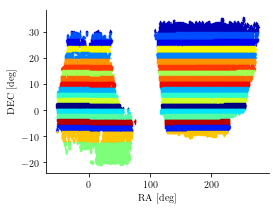

In [4]:
from utils import split_jackknife, hpix2radec
params = {
'axes.spines.right':False,
'axes.spines.top':False,
'axes.labelsize': 10,
#'text.fontsize': 8,
'legend.fontsize': 10,
'xtick.labelsize': 10,
'ytick.labelsize': 10,
'text.usetex': True,
'figure.figsize': [4, 3],
'font.family':'serif',
'font.size':10
}
plt.rcParams.update(params)            


# read the mask of DR7
mask = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.cut.hp.256.fits', verbose=False).astype('bool')
frac = hp.read_map('/Volumes/TimeMachine/data/DR7/frac.hp.256.fits', verbose=False)
# plot the jackknife reg
dummy = np.ones(mask.sum())
hpixl, fracs,_,_ = split_jackknife(np.argwhere(mask).flatten(), frac[mask], dummy, dummy, njack=20)
print('total fracgood', frac[mask].sum())
print('total fracgood', sum([sum(fracs[i]) for i in range(len(fracs))]))



jj = np.random.choice(np.arange(20), size=20, replace=False)
cl = plt.cm.jet
n  = len(hpixl)
for i,hpixi in enumerate(hpixl):
    radec = hpix2radec(256, hpixi)
    ramm  = radec[0] > 300
    radec[0][ramm] -= 360. 
    plt.scatter(*radec, 0.05,  color=cl(jj[i]/n), alpha=1.0)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.savefig('./figs/jackknifes.png', bbox_inches='tight', dpi=300)

## MOCKS

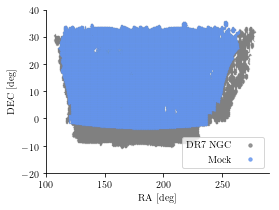

In [39]:
def plot_mock_on_dr(maskm, maskd):
    from utils import hpix2radec
    params = {
    'axes.spines.right':False,
    'axes.spines.top':False,
    'axes.labelsize': 10,
    #'text.fontsize': 8,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': True,
    'figure.figsize': [4, 3],
    'font.family':'serif',
    'font.size':10
    }
    plt.rcParams.update(params)            


    mockm  = hp.read_map(maskm, verbose=False).astype('bool')
    mockd  = hp.read_map(maskd, verbose=False).astype('bool')
    radecm = hpix2radec(256, np.argwhere(mockm).flatten())
    radecd = hpix2radec(256, np.argwhere(mockd).flatten())
    #ramm   = radecd[0] > 300
    #radecd[0][ramm] -= 360. 


    plt.figure()
    plt.scatter(*radecd, 0.05, marker='o', color='grey',    label='DR7 NGC', alpha=0.8)
    plt.scatter(*radecm, 0.05, marker='o', color='cornflowerblue', label='Mock',    alpha=0.8)
    plt.axis([100., 290., -20., 40.])
    plt.legend(markerscale=15, markerfirst=False)
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.savefig('./figs/mockondr.png', bbox_inches='tight', dpi=300)
    #
maskm = '/Volumes/TimeMachine/data/mocks/mask.hp.256.fits'
maskd = '/Volumes/TimeMachine/data/DR7/mask.hp.256.fits'
plot_mock_on_dr(maskm, maskd)

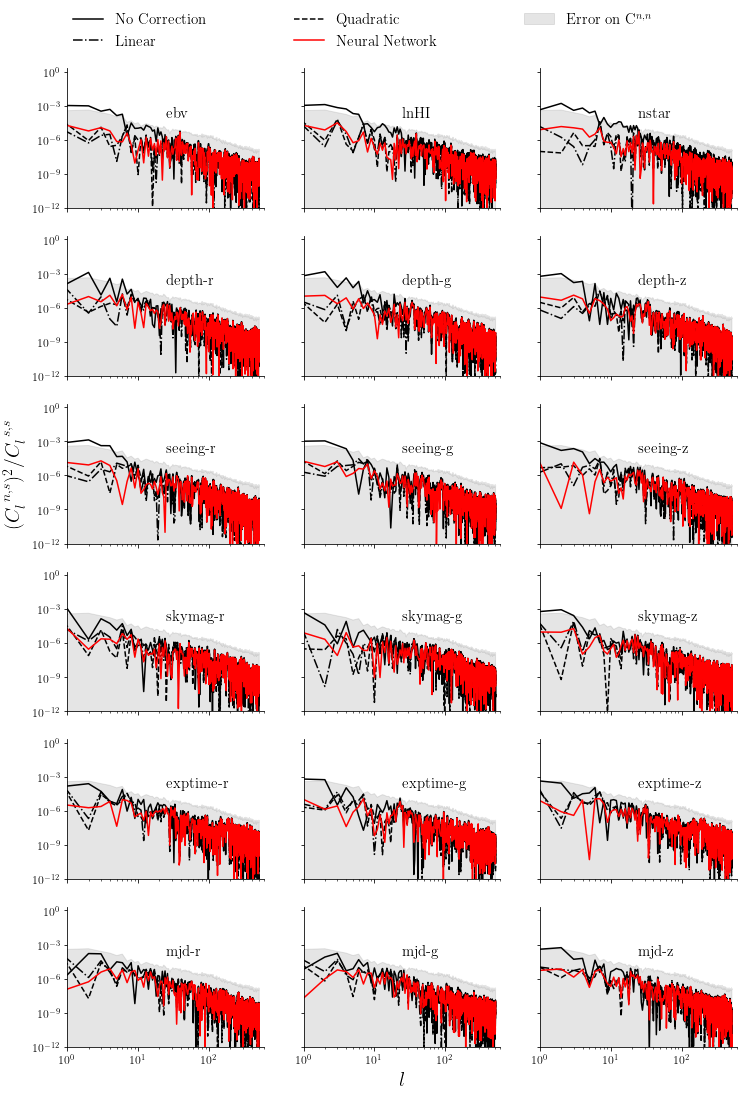

In [58]:
def plot_cl_cross_dr(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 20,
   #'text.fontsize': 8,
   'legend.fontsize': 15,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':12
   }
    plt.rcParams.update(params)
    #plt.rc('xtick', labelsize='medium')
    #plt.rc('ytick', labelsize='medium')
    ND = len(config['crosscl']['flb'])
    #c  = plt.cm.jet # goes with c(i/ND)
    c  = ['k', 'k', 'k', 'r']    
    ls = ['-','-.','--', '-']
    
    pltarg = dict(ncols=3, nrows=6, sharex=True, figsize=(3*4, 6*3), sharey=True)
    tckfmt = dict(style='sci', axis='y', scilimits=(0,0))
#     lgnarg = dict(bbox_to_anchor=(1.1, 0.9), frameon=False, ncol=1, 
#                   title=config['crosscl']['title'], fontsize=15)
    lgnarg = dict(ncol=3,frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0)        
    xlim   = (1.0, 600)
    ylim   = (1.e-12, 2.)#(-1., 5.)
    clsys  = np.load(config['crosscl']['clsys']).item()
    #
    #  PLOT
    #
    def add_plot(fs, a, color='b', label='none', ls='-', clsys=clsys, adderr=False):    
        d = np.load(fs).item()
        for i in range(d['cross'].shape[0]):
            l = np.arange(d['cross'][i, :].size)
            cl= d['cross'][i, :]**2 / clsys['cross'][i, :]
            a[i].plot(l, cl, color=color, label=label, linestyle=ls)

        if adderr:
            for i in range(d['cross'].shape[0]):
                l = np.arange(d['clerr']['clerr'].size)
                cl= d['clerr']['clerr']
                #a[i].plot(l, 1+1.e4*cl, color='grey', linestyle=':', label=r'Error on C$^{n,n}$')
                a[i].fill_between(l, 1.e-13, cl, color='grey', label=r'Error on C$^{n,n}$', alpha=0.2)
            

    f,a    = plt.subplots(**pltarg)
    # plt.subplots_adjust(hspace=0.0, wspace=0.0)
    a = a.flatten()
    for i, fi in enumerate(config['crosscl']['flb']):
        if fi == 'uni':
            adderr = True
        else:
            adderr = False
        add_plot(config['crosscl']['clpath'](fi), a, c[i] , config['crosscl']['lb'][i], ls[i], adderr=adderr)
    
    for i in range(len(a)):
        if i ==6:a[i].set_ylabel(r'$(C^{~n,s}_{l})^{2}/C^{~s,s}_{l}$')
        if i ==16:a[i].set_xlabel('$l$')
        a[i].text(0.5, 0.65, r'%s'\
                          %config['crosscl']['xticks'][i], transform=a[i].transAxes, fontsize=15)
        #a[i].ticklabel_format(**tckfmt)
        #a[i].tick_params(axis='y', pad=1.0)
        a[i].set_xscale('log')
        a[i].set_yscale('log')
        a[i].set_xlim(*xlim)
        a[i].set_ylim(*ylim)        
    a[0].legend(**lgnarg)
    #f.delaxes(a[17])

    plt.savefig(config['crosscl']['ouname'], bbox_inches='tight')
plot_cl_cross_dr(config)

4.0423053735266965e-33
3.1919330994763744e-33
3.8260821413566665e-32
1.2394972044592943e-32


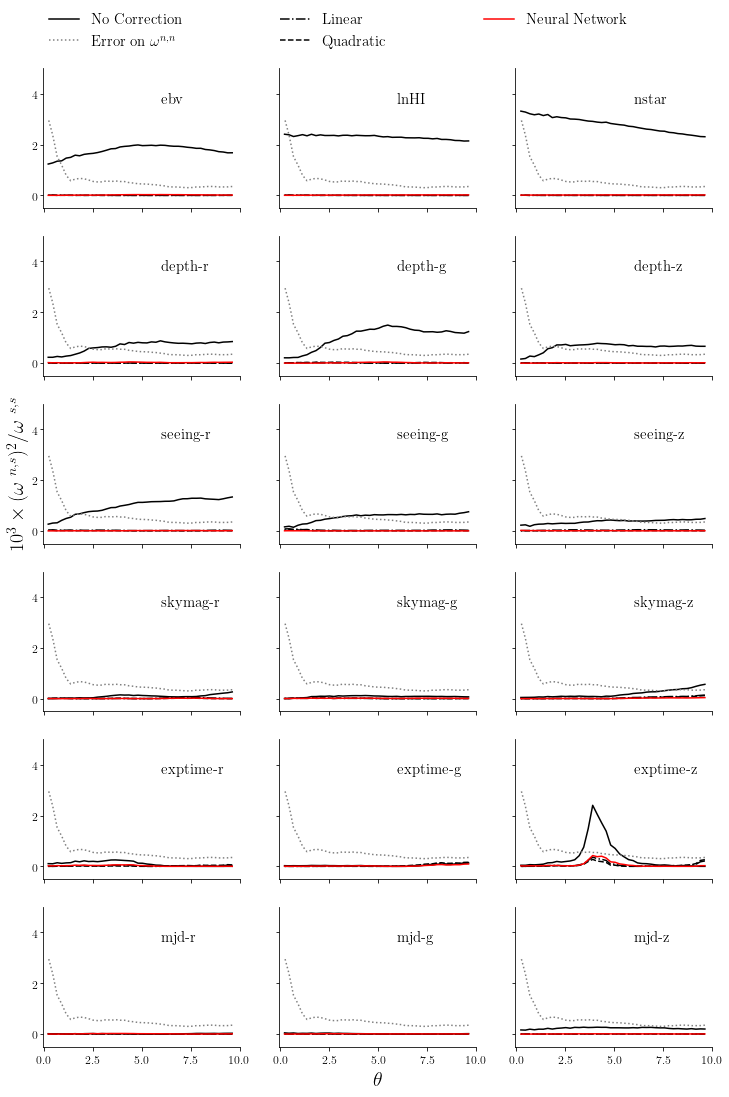

In [36]:
def plot_cl_cross_xi(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 20,
   #'text.fontsize': 8,
   'legend.fontsize': 15,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':12
   }
    plt.rcParams.update(params)
    #plt.rc('xtick', labelsize='medium')
    #plt.rc('ytick', labelsize='medium')
    ND = len(config['crossxi']['flb'])
    #c  = plt.cm.jet
    c  = ['k', 'k', 'k', 'r']    
    ls = ['-','-.','--', '-']

    pltarg = dict(ncols=3, nrows=6, sharex=True, figsize=(3*4, 6*3), sharey=True)
    tckfmt = dict(style='sci', axis='y', scilimits=(0,0))
#     lgnarg = dict(bbox_to_anchor=(1.1, 0.9), frameon=False, ncol=1, 
#                   title=config['crosscl']['title'], fontsize=15)
    lgnarg = dict(ncol=3,frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0)        
    xlim   = (-0.05, 10)
    ylim   = (-.5, 5.)
    clsys  = np.load(config['crossxi']['xisys']).item()
    #print(clsys['cross'][0]['w'])
    #
    #  PLOT
    #
    def add_plot(fs, a, color='b', label='none', ls='-', clsys=clsys, err=False, addauto=False):    
        d = np.load(fs).item()
        xit = d['auto']['werr']# - d['auto']['dmean']**2
        print(d['auto']['dmean']**2)
        #return 
        for i in range(len(d['cross'])):
            mc  = clsys['cross'][i]['w'][0]/clsys['cross'][i]['w'][1] - clsys['cross'][i]['dmean']**2            
            myd = d['cross'][i]
            l   = np.degrees(myd['t'][1:])            
            cl  = 1.e3*(myd['w'][0]/myd['w'][1]-myd['dmean1']*myd['dmean2'])**2/mc
            if err:
                cle = 1.e3*myd['werr']**2/mc
                a[i].errorbar(l, cl, yerr=cle, color=color, label=label, linestyle=ls)
            else:
                a[i].plot(l, cl, color=color, label=label, linestyle=ls)
            if addauto:
                a[i].plot(l, 1.e3*xit, color='grey', linestyle=':', label=r'Error on $\omega^{n,n}$')

    f,a    = plt.subplots(**pltarg)
    # plt.subplots_adjust(hspace=0.0, wspace=0.0)
    a = a.flatten()
    for i, fi in enumerate(config['crossxi']['flb']):
        if fi =='uni':
            addauto=True
        else:
            addauto=False
        add_plot(config['crossxi']['xipath'](fi), a, c[i], config['crossxi']['lb'][i], ls[i], addauto=addauto)
    for i in range(len(a)):
        if i ==6:a[i].set_ylabel(r'$10^{3}\times(\omega^{~n,s})^{2}/\omega^{~s,s}$')
        if i ==16:a[i].set_xlabel(r'$\theta$')
        a[i].text(0.6, 0.75, r'%s'\
                          %config['crossxi']['xticks'][i], transform=a[i].transAxes, fontsize=15)
        a[i].ticklabel_format(**tckfmt)
        a[i].tick_params(axis='y', pad=1.0)
        a[i].set_xlim(*xlim)
        a[i].set_ylim(*ylim)        
    a[0].legend(**lgnarg)
    #f.delaxes(a[17])

    plt.savefig(config['crossxi']['ouname'], bbox_inches='tight')
plot_cl_cross_xi(config)

In [14]:
# def plot_ablation(config):
#     params = {
#    'axes.spines.right':False,
#    'axes.spines.top':False,
#    'axes.labelsize': 10,
#    #'text.fontsize': 8,
#    'legend.fontsize': 10,
#    'xtick.labelsize': 10,
#    'ytick.labelsize': 10,
#    'text.usetex': True,
#    #'figure.figsize': [4, 3],
#    'font.family':'serif',
#     'font.size':10
#    }
#     plt.rcParams.update(params)
    
#     ND = len(config['mocks_ablation']['xticks'])
#     f, a = plt.subplots(figsize=(4, 3))
#     a.set_xticklabels(config['mocks_ablation']['xticks'], rotation=90)
#     a.set_xticks(np.arange(ND))
#     def get_important(filed):
#         files = glob(filed)
#         important = []
#         for uli in files:
#             d = np.load(uli).item()
#             im = np.setdiff1d(np.arange(ND), d['importance'])[0]
#             #if im not in [4, 16]:print(uli)
#             important.append(im)
#             #important.append(d['importance'][-1])
#         return important

#     imu = get_important(config['mocks_ablation']['uncont.'])
#     imc = get_important(config['mocks_ablation']['cont.'])
#     kw = dict(bins=np.arange(0, ND+1, 1), align='left', alpha=0.4)
#     a.hist(imc, color='r', label='contaminated', **kw, hatch='/')
#     a.hist(imu, color='b', label='uncontaminated', **kw)
#     a.set_xlabel('Most important feature from Ablation')
#     a.set_ylabel('Number of mocks')
#     a.legend(title=config['mocks_ablation']['title'])
#     plt.savefig(config['mocks_ablation']['ouname'], bbox_inches='tight')
# plot_ablation(config)

In [15]:
# def plot_cf(config):
#     params = {
#    'axes.spines.right':False,
#    'axes.spines.top':False,
#    'axes.labelsize': 10,
#    #'text.fontsize': 8,
#    'legend.fontsize': 10,
#    'xtick.labelsize': 10,
#    'ytick.labelsize': 10,
#    'text.usetex': True,
#    #'figure.figsize': [4, 3],
#    'font.family':'serif',
#     'font.size':10
#    }
#     plt.rcParams.update(params)    
#     def get_cf(l, fs):
#         cf = []
#         for i in range(fs.shape[1]):
#             cf.append(pearsonr(l, fs[:, i])[0])
#         return np.array(cf)
#     def bootstrap(l, fs, n=100):
#         CF = []
#         for i in range(n):
#             #if i % 100==0:print(i)
#             lb = np.random.permutation(l)
#             CF.append(get_cf(lb, fs))
#         return np.array(CF)

#     def cfs(ls, cf, CF, ou='./dr7_ccs.pdf', cf2=None, lbs=['DR7'], ylim=(-0.2, 0.2)):
#         nsys = CF.shape[1]
#         D = np.zeros(nsys, dtype=np.dtype([('cf', 'f8'), ('lb', 'i'), ('std', 'f8'), ('cf2', 'f8')]))
#         x = np.arange(nsys)
#         D['lb'] = x
#         D['cf'] = cf
#         if cf2 is not None:D['cf2'] = cf2
#         D['std']= np.std(CF, axis=0)
#         Ds = np.sort(D, order='cf')
#         lss = [ls[i] for i in Ds['lb']]


#         f,a=plt.subplots(figsize=(4,3))
#         a.fill_between(x, -3*Ds['std'], 3*Ds['std'], alpha=0.2,
#                        color='blue', label=r'3$\sigma$ C.L.')
#         a.scatter(x, Ds['cf'], s=15, c='r', label=lbs[0], marker='x')
#         if cf2 is not None:
#             a.scatter(x, Ds['cf2'], s=15, c='purple', label=lbs[1], marker='^')
#         a.set_ylabel(r"$\rho_{ngal, X}$")
#         a.set_xlabel('Features')
#         a.set_xticks(x)
#         a.set_xticklabels(lss, rotation=90)
#         a.legend(title='A single mock realization')
#         a.set_ylim(*ylim)
#         plt.savefig(ou, bbox_inches='tight')
#     #d = hp.read_map(config['ccplot']['ngal'])
#     #fr= hp.read_map(config['ccplot']['frac'])
#     #f = ft.read(config['ccplot']['feats'])
#     #labs = d[f['hpix']]/fr[f['hpix']]
#     #feats = f['features']
#     #cf = get_cf(labs, feats)
#     #CF = bootstrap(labs, feats, n=100)
#     #ls = config['ccplot']['xticks']
#     #cfs(ls, cf, CF, config['ccplot']['ouname'], lbs=[config['ccplot']['label']], ylim=(-0.2, 0.2))
#     # mock
#     d   = hp.read_map('/Volumes/TimeMachine/data/mocks/3dbox/019/c4n/019.c4n.hp.256.fits')
#     d2  = hp.read_map('/Volumes/TimeMachine/data/mocks/3dbox/019/019.hp.256.fits')
#     f   = ft.read('/Volumes/TimeMachine/data/mocks/dr5mock-features.fits')
#     fr  = hp.read_map('/Volumes/TimeMachine/data/mocks/mock.fracNgalhpmap.fits')
#     cf1 = get_cf(d[f['hpix']]/fr[f['hpix']], f['features'])
#     cf2 = get_cf(d2[f['hpix']]/fr[f['hpix']], f['features'])
#     CF1 = bootstrap(d[f['hpix']]/fr[f['hpix']], f['features'], n=100)
#     ls = ['ebv', 'nstar'] \
#       + [''.join([s,'-',b]) for s in ['depth', 'seeing', 'airmass','skymag','exptime']\
#      for b in 'rgz']
#     cfs(ls, cf1, CF1, './mocks_ccs.pdf', cf2=cf2,
#              lbs=['Contaminated mock', 'Uncontaminated mock'], ylim=(-0.08, 0.12))
# # plot ccplot    
# plot_cf(config)

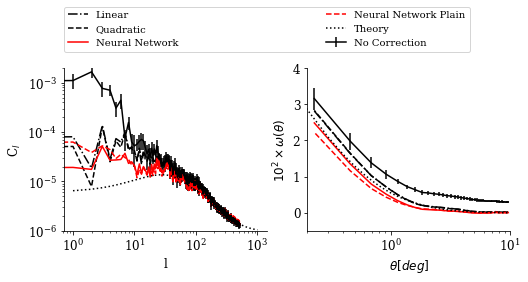

In [71]:
def plot_2dclus(config):    
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 12,
   #'text.fontsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':10
   }
    plt.rcParams.update(params)    
    cl = np.loadtxt(config['2dclustering']['cl_theory'], usecols=(1))
    c  = ['k', 'k', 'k', 'r', 'r']    
    ls = ['-','-.','--', '-', '--']
    Nd = len(config['2dclustering']['flb'])
    fig, ax = plt.subplots(ncols=2,figsize=(8, 3))
    bias = 8.559653560332259e-07
    #
    # C_l
    #
    for i,l in enumerate(config['2dclustering']['flb']):
        d = np.load(config['2dclustering']['clpath'](l)).item()
        #if l == 'nns':print(d['auto'][:5])
        if l =='uni':
            ax[0].errorbar(np.arange(d['auto'].size), d['auto'], yerr=d['clerr']['clerr'],#-0.1*d['auto'][-1],
                  color=c[i], ls=ls[i], label=config['2dclustering']['lb'][i]) #label=config['2dclustering']['lb'][i],
        else:
            ax[0].plot(np.arange(d['auto'].size), d['auto'],#-0.1*d['auto'][-1],
                  color=c[i], ls=ls[i], label=config['2dclustering']['lb'][i]) #label=config['2dclustering']['lb'][i],
    ax[0].plot(np.arange(1, cl.size+1), 2.**2*cl+bias, 'k:', label='Theory')    
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('l')
    ax[0].set_ylabel(r'C$_{l}$')
    ax[0].set_ylim(1.e-6, 2.e-3)


    fc = 1.e2
    tt, xit = np.loadtxt('/Users/rezaie/github/DESILSS/tests/lssdata/fftlog_xi.out', usecols=(0,1), unpack=True)


    
    for i,l in enumerate(config['2dclustering']['flb']):
        d = np.load(config['2dclustering']['xipath'](l)).item()['auto']
        #print(d['auto']['t'].keys())
        #break
        
        t  = np.degrees(d['t'])[1:]    
        xi = fc*(d['w']-d['dmean']*d['dmean'])
        #print(d.keys())
        if l == 'uni':
            xierr=d['werr']
            ax[1].errorbar(t, xi, yerr=fc*xierr, label=config['2dclustering']['lb'][i], color=c[i], ls=ls[i])
        else:
            ax[1].plot(t, xi, label=config['2dclustering']['lb'][i], color=c[i], ls=ls[i])
    ax[1].plot(tt, 2**2*fc*xit, ':', color='k', label='Theory')
    ax[0].legend(bbox_to_anchor=(0, 1.1, 2, 0.4), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)    
    ax[1].set_xlabel(r'$\theta [deg]$')
    ax[1].set_ylabel(r'$10^{2}\times\omega(\theta)$')
    ax[1].set_xlim(0.2, 10)
    ax[1].set_ylim(-0.5, 4.0)
    ax[1].set_xscale('log')
    #plt.savefig(config['2dclustering']['ouname'], bbox_inches='tight')
plot_2dclus(config)

In [16]:
frac = hp.read_map('/Volumes/TimeMachine/data/DR7/frac.hp.256.fits')
mask = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.cut.hp.256.fits').astype('bool')
ngal = hp.read_map('/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.cut.hp256.fits')

area = hp.nside2pixarea(256, degrees=True)*frac[mask].sum()*3.0462e-4
area

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


2.8697488270433706

In [17]:
2.8697488270433706/ngal[mask].sum()

8.559653560332259e-07

['uni', 'lin', 'quad', 'nn_ab']
[20535.25633393  2251.04699062  2124.47211106   962.83463621]
[360. 360. 360. 360.]
[57.04237871  6.25290831  5.90131142  2.67454066]


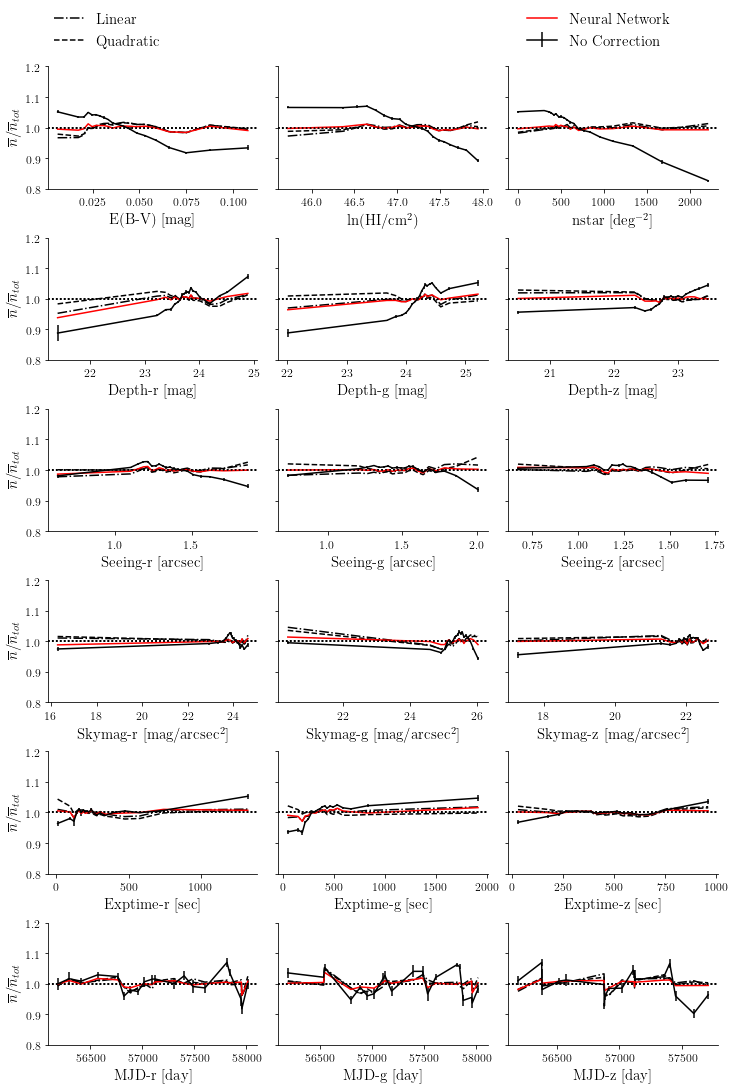

In [42]:
def plot_nnbar(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 15,
   #'text.fontsize': 8,
   'legend.fontsize': 15,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':12
   }    
    xlabels = ['E(B-V) [mag]', r'ln(HI/cm$^{2}$)', r'nstar [deg$^{-2}$]']\
             + ['Depth-'+b+' [mag]' for b in 'rgz'] \
             + ['Seeing-'+b+' [arcsec]' for b in 'rgz'] \
             + [r'Skymag-'+b+' [mag/arcsec$^{2}$]' for b in 'rgz'] \
             + ['Exptime-'+b+' [sec]' for b in 'rgz'] \
             + ['MJD-'+b+' [day]' for b in 'rgz']    
    plt.rcParams.update(params)    
    lgnarg = dict(ncol=2,frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0)    
    def chi2 (x, y, ye): 
        dx = np.diff(x)[2]
        m = (~np.isnan(y)) & (~np.isnan(ye) & (ye != 0.0))
        terms = (y[m]-1.0)/ye[m]
        worst = x[m][np.argmax(terms)]
        return np.sum(terms**2), m.sum()
    c  = ['k', 'k', 'k', 'r']    
    ls = ['-','-.','--', '-']
    Nd = len(config['nnbarplot']['flb'])
    fig, ax = plt.subplots(ncols=3, nrows=6, sharey=True, figsize=(12, 18)) # 10, 16.5
    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    ax = ax.flatten()
    #fig.delaxes(ax[-1])
    def add_ax(ax, res, shift=1.0, step=True, **kw):
        m = (~ np.isnan(res['nnbar'])) & (res['nnbar_err']!=0.0)
        if step:
            ax.errorbar(res['bin_edges'][:-1][m]*shift, res['nnbar'][m],
                     yerr=res['nnbar_err'][m], **kw)
        else:
            ax.plot(res['bin_edges'][:-1][m]*shift, res['nnbar'][m], **kw)        
        ax.axhline(1, linestyle=':', color='k')
        #if step:ax.fill_between(res['bin_edges'][:-1][m], 1-res['nnbar_err'][m], 1+res['nnbar_err'][m], color='grey')
#         ax2 = ax.twinx()
#         ax2.set_yticks([])
        #ax2.set_ylim(0, 600)
#         if step:ax2.step(res['bin_edges'][:-1][m], res['area'][m], where='post',
#                          linestyle=':', color='grey', alpha=0.3)
    CHIS = np.zeros(Nd)
    DOFS = np.zeros(Nd)
    for i,df in enumerate(config['nnbarplot']['flb']):
        di = np.load(config['nnbarplot']['nnbarpath'](df)).item()
        for j in range(len(di['xlabels'])):
            if i ==0:
                step=True
            else:
                step=False
            add_ax(ax[j], di['nnbar'][j], color=c[i], ls=ls[i], label=config['nnbarplot']['lb'][i], step=step)
            ci2, dof = chi2(di['nnbar'][j]['bin_edges'][:-1], di['nnbar'][j]['nnbar'], di['nnbar'][j]['nnbar_err'])
            CHIS[i] += ci2
            DOFS[i] += dof
            if i==0:
                if j%3 == 0:ax[j].set_ylabel(r'$\overline{n}/\overline{n}_{tot}$')
                #ax[j].set_xlabel(di['xlabels'][j])
                ax[j].set_xlabel(xlabels[j])
                ax[j].set_ylim(0.8, 1.2)
                ax[j].locator_params(tight=True, nbins=5)
        #if i ==1:ax[i].set_xlim(xmax=6000)
    ax[0].legend(**lgnarg)
    print(config['nnbarplot']['flb'])
    print(CHIS)
    print(DOFS)
    print(CHIS/DOFS)
    #plt.savefig('./figs/nnbar_dr7.pdf', bbox_inches='tight')
plot_nnbar(config)

## MOCKS

Cont. False
Null True
Cont. with Linear False
Cont. with Quadaratic False
Cont. with Neural Network False
Cont. w NN wo Ab False


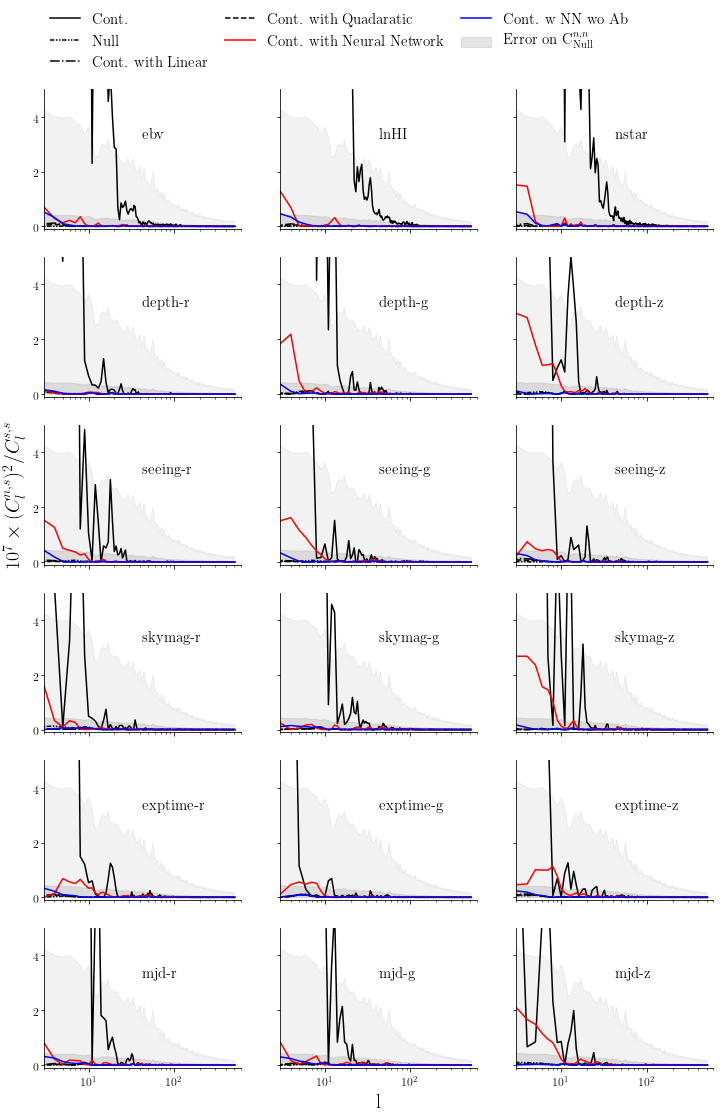

In [13]:
def plot_cl_cross_mocks():
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 20,
   #'text.fontsize': 8,
   'legend.fontsize': 15,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':12
   }
    plt.rcParams.update(params)
    c  = ['k', 'k', 'k', 'k', 'r', 'b']    
    ls = ['-',(0, (3, 1, 1, 1, 1, 1)), '-.','--', '-','-']    
    path = '/Volumes/TimeMachine/data/mocks/3dbox/'
    clsys = np.load('/Volumes/TimeMachine/data/mocks/3dbox/cl_sys.npy').item()
    
    #
    #  INPUTS
    u_u = glob(path  + '*/results/clustering/cl_uni.npy')
    c_u = glob(path  + '*/cp2p/results/clustering/cl_uni.npy')
    u_l = glob(path  + '*/cp2p/results/clustering/cl_lin.npy')
    u_q = glob(path  + '*/cp2p/results/clustering/cl_quad.npy')
    u_nb = glob(path + '*/cp2p/results/clustering/cl_nn.npy')
    u_n = glob(path + '*/cp2p/results/clustering/cl_nn_p.npy')
    
    fls = [c_u, u_u, u_l, u_q, u_nb, u_n]
#           c_u, c_l, c_q, c_nb, c_f]
    lb = ['Cont.', 'Null', 'Cont. with Linear', 
          'Cont. with Quadaratic', 
          'Cont. with Neural Network', 'Cont. w NN wo Ab']#,
#           'Contaminated', 'Contaminated with linear weights', 
#           'Contaminated with quadratic weights', 
#           'Contaminated with NN weights', 'Contaminated with linear (few maps)']
    #      'Contaminated with NN-Ablation weights']
    d = len(lb)
    labels = ['ebv', 'lnHI', 'nstar']+ [s+'-'+b for s in 
                       ['depth', 'seeing', 'skymag','exptime', 'mjd'] for b in 'rgz']    
    pltarg = dict(ncols=3, nrows=6, sharex=True, sharey=True, figsize=(12, 18))
    tckfmt = dict(style='sci', axis='y', scilimits=(0,0))
    lgnarg = dict(ncol=2,frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0) #bbox_to_anchor=(1., 1.0),
    xlim   = (.9, 600)
    
    pltarg = dict(ncols=3, nrows=6, sharex=True, figsize=(3*4, 6*3), sharey=True)
    tckfmt = dict(style='sci', axis='y', scilimits=(0,0))
#     lgnarg = dict(bbox_to_anchor=(1.1, 0.9), frameon=False, ncol=1, 
#                   title=config['crosscl']['title'], fontsize=15)
    lgnarg = dict(ncol=3, frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0)        
    xlim   = (3, 600)
    ylim   = (-0.1, 5.)

    
    #ylim   = (-1.2e-7, 1.2e-7)
    #print(len(u_u), len(c_u), len(c_l), len(c_nb), len(c_nr))
    #
    #  PLOT
    #
    def add_plot(fs, a, color='b', label='none', ls='-', fill=False):    
        dall = np.zeros((18,513, 100))
        clat = []
        for i,fi in enumerate(fs):
            #if i%50==0:print(i)
            d = np.load(fi).item()
            dall[:,:,i] = d['cross']
            clat.append(d['auto'])
        # 
        nn = np.sqrt(len(fs))
        dall_mean = np.mean(dall, axis=2)
        #dall_std  = np.std(dall, axis=2)/nn
        #
        for i in range(dall.shape[0]):
            l = np.arange(dall_mean[i,:].size)
            cl= 1.0e7*dall_mean[i,:]**2 / clsys['cross'][i,:]
            #ce= 1.0e6*dall_std[i,:]**2 / clsys['cross'][i,:]
            a[i].plot(l, cl, color=color, label=label, linestyle=ls)
            if fill:
                cerr = np.std(np.array(clat), axis=0, ddof=1)/10.
                #a[i].plot(l, 1.0e7*cerr, color='k', linestyle=':', label=r'Error on C$^{n,n}_{{\rm Null}}$')
                a[i].fill_between(l, 0, 1.0e7*cerr, color='grey', alpha=0.2, label=r'Error on C$^{n,n}_{{\rm Null}}$')
                a[i].fill_between(l, 0, 1.0e7*nn*cerr, color='grey', alpha=0.1)
                #a[i].fill_between(l, cl-ce, cl+ce, color=color, alpha=0.2)
                #a[i].fill_between(l, cl-ce*nn, cl+ce*nn, color=color, alpha=0.1)
                #a[i].set_ylim(-1.5*np.max(cl+ce), 1.5*np.max(cl+ce))


    f,a    = plt.subplots(**pltarg)
    # plt.subplots_adjust(hspace=0.0, wspace=0.0)
    #c = plt.cm.jet
    a = a.flatten()
    for i, fi in enumerate(fls):
        if lb[i] in ['Null']:
            fill=True
        else:
            fill=False
        print(lb[i], fill)
        add_plot(fi, a, c[i], lb[i], ls[i], fill=fill)
    for i in range(len(a)):
        if i ==6:a[i].set_ylabel(r'$10^{7}\times(C^{n,s}_{l})^{2}/C^{s,s}_{l}$')
        if i ==16:a[i].set_xlabel('l')
        a[i].text(0.5, 0.65, r'%s'\
                          %labels[i], transform=a[i].transAxes, fontsize=15)            
        #if i<17:a[i].text(0.4,0.2, r'Ngal $\times$ %s'\
        #                  %labels[i], transform=a[i].transAxes)
        a[i].ticklabel_format(**tckfmt)
        a[i].tick_params(axis='y', pad=1.0)
        a[i].set_xscale('log')
        a[i].set_xlim(*xlim)
        a[i].set_ylim(*ylim)        
    a[0].legend(**lgnarg)
    #f.delaxes(a[17])
    plt.savefig('./figs/cl-cross-mock.pdf', bbox_inches='tight')
plot_cl_cross_mocks()

Null True
Null with Linear False
Null with Quadaratic False
Null with Neural Network False
Null with NN wo Ab False


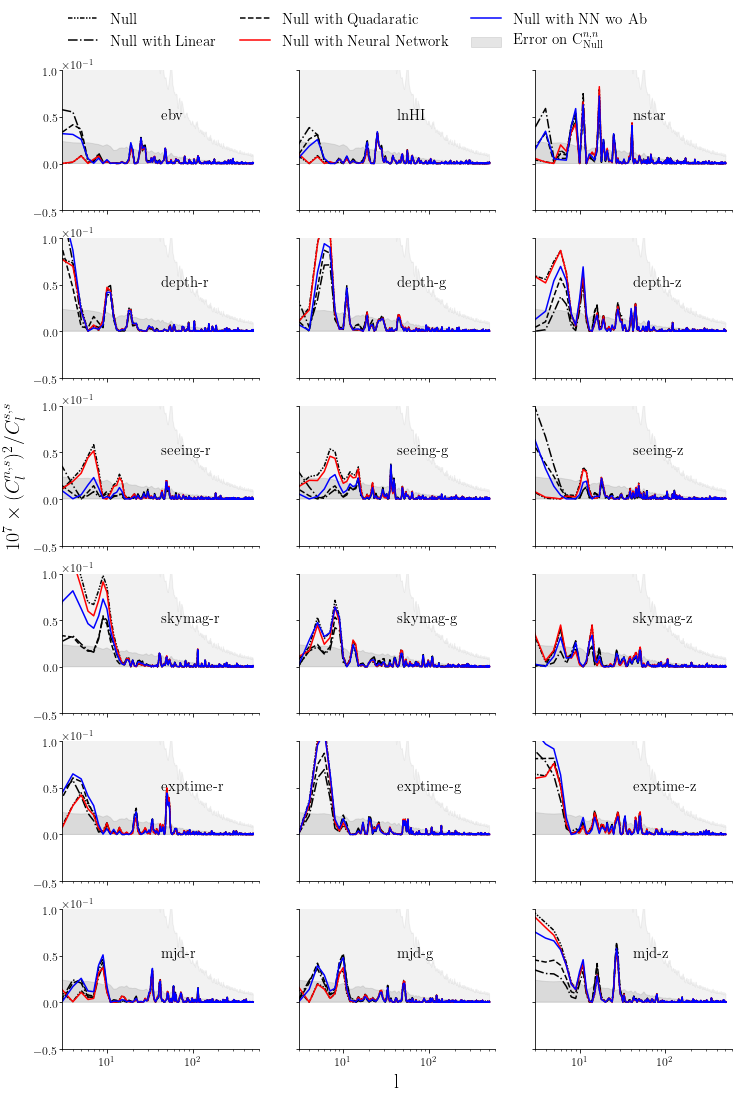

In [10]:
def plot_cl_cross_nmocks():
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 20,
   #'text.fontsize': 8,
   'legend.fontsize': 15,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':12
   }
    plt.rcParams.update(params)
    c  = ['k', 'k', 'k', 'r', 'b']    
    ls = [(0, (3, 1, 1, 1, 1, 1)), '-.','--', '-', '-']    
#     ls = 5*['-','-.','--', '-']
    path = '/Volumes/TimeMachine/data/mocks/3dbox/'
    clsys = np.load('/Volumes/TimeMachine/data/mocks/3dbox/cl_sys.npy').item()
    
    #
    #  INPUTS
    u_u = glob(path  + '*/results/clustering/cl_uni.npy')
    u_l = glob(path  + '*/results/clustering/cl_lin.npy')
    u_q = glob(path  + '*/results/clustering/cl_quad.npy')
    u_nb = glob(path + '*/results/clustering/cl_nn.npy')
    u_n = glob(path + '*/results/clustering/cl_nn_p}.npy')    
    fls = [u_u, u_l, u_q, u_nb, u_n]
#           c_u, c_l, c_q, c_nb, c_f]
    lb = ['Null', 'Null with Linear', 
          'Null with Quadaratic', 
          'Null with Neural Network',
         'Null with NN wo Ab']#,
#           'Contaminated', 'Contaminated with linear weights', 
#           'Contaminated with quadratic weights', 
#           'Contaminated with NN weights', 'Contaminated with linear (few maps)']
    #      'Contaminated with NN-Ablation weights']
    d = len(lb)
    labels = ['ebv', 'lnHI', 'nstar']+ [s+'-'+b for s in 
                       ['depth', 'seeing', 'skymag','exptime', 'mjd'] for b in 'rgz']    
    pltarg = dict(ncols=3, nrows=6, sharex=True, sharey=True, figsize=(12, 18))
    tckfmt = dict(style='sci', axis='y', scilimits=(0,0))
    lgnarg = dict(ncol=2,frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0) #bbox_to_anchor=(1., 1.0),
    xlim   = (.9, 600)
    
    pltarg = dict(ncols=3, nrows=6, sharex=True, figsize=(3*4, 6*3), sharey=True)
    tckfmt = dict(style='sci', axis='y', scilimits=(0,0))
#     lgnarg = dict(bbox_to_anchor=(1.1, 0.9), frameon=False, ncol=1, 
#                   title=config['crosscl']['title'], fontsize=15)
    lgnarg = dict(ncol=3, frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0)        
    xlim   = (3, 600)
    ylim   = (-.05, .1)

    
    #ylim   = (-1.2e-7, 1.2e-7)
    #print(len(u_u), len(c_u), len(c_l), len(c_nb), len(c_nr))
    #
    #  PLOT
    #
    def add_plot(fs, a, color='b', label='none', ls='-', fill=False):    
        dall = np.zeros((18,513, 100))
        clat = []
        for i,fi in enumerate(fs):
            #if i%50==0:print(i)
            d = np.load(fi).item()
            dall[:,:,i] = d['cross']
            clat.append(d['auto'])
        # 
        nn = np.sqrt(len(fs))
        dall_mean = np.mean(dall, axis=2)
        #dall_std  = np.std(dall, axis=2)/nn
        #
        for i in range(dall.shape[0]):
            l = np.arange(dall_mean[i,:].size)
            cl= 1.0e7*dall_mean[i,:]**2 / clsys['cross'][i,:]
            #ce= 1.0e6*dall_std[i,:]**2 / clsys['cross'][i,:]
            a[i].plot(l, cl, color=color, label=label, linestyle=ls)
            if fill:
                cerr = np.std(np.array(clat), axis=0, ddof=1)/10.
                #a[i].plot(l, 1.0e7*cerr, color='k', linestyle=':', label=r'Error on C$^{n,n}_{{\rm Null}}$')
                a[i].fill_between(l, 0, 1.0e7*cerr/18., color='grey', alpha=0.2, label=r'Error on C$^{n,n}_{{\rm Null}}$')
                a[i].fill_between(l, 0, 1.0e7*nn*cerr/18., color='grey', alpha=0.1)
                #a[i].fill_between(l, cl-ce, cl+ce, color=color, alpha=0.2)
                #a[i].fill_between(l, cl-ce*nn, cl+ce*nn, color=color, alpha=0.1)
                #a[i].set_ylim(-1.5*np.max(cl+ce), 1.5*np.max(cl+ce))


    f,a    = plt.subplots(**pltarg)
    # plt.subplots_adjust(hspace=0.0, wspace=0.0)
    #c = plt.cm.jet
    a = a.flatten()
    for i, fi in enumerate(fls):
        if lb[i] in ['Null']:
            fill=True
        else:
            fill=False
        print(lb[i], fill)
        add_plot(fi, a, c[i], lb[i], ls[i], fill=fill)
    for i in range(len(a)):
        if i ==6:a[i].set_ylabel(r'$10^{7}\times(C^{n,s}_{l})^{2}/C^{s,s}_{l}$')
        if i ==16:a[i].set_xlabel('l')
        a[i].text(0.5, 0.65, r'%s'\
                          %labels[i], transform=a[i].transAxes, fontsize=15)            
        #if i<17:a[i].text(0.4,0.2, r'Ngal $\times$ %s'\
        #                  %labels[i], transform=a[i].transAxes)
        a[i].ticklabel_format(**tckfmt)
        a[i].tick_params(axis='y', pad=1.0)
        a[i].set_xscale('log')
        a[i].set_xlim(*xlim)
        a[i].set_ylim(*ylim)        
    a[0].legend(**lgnarg)
    #f.delaxes(a[17])
#     plt.savefig('./figs/cl-cross-mock.pdf', bbox_inches='tight')
plot_cl_cross_nmocks()

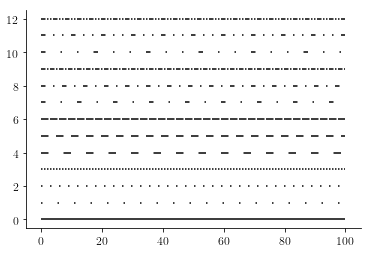

In [27]:
from collections import OrderedDict

linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])


fig, ax = plt.subplots()

X, Y = np.linspace(0, 100, 10), np.zeros(10)
for i, (name, linestyle) in enumerate(linestyles.items()):
    ax.plot(X, Y+i, linestyle=linestyle, linewidth=1.5, color='black')

ax.set_ylim(-0.5, len(linestyles)-0.5)

plt.show()

In [ ]:
ls /Volumes/TimeMachine/data/mocks/3dbox/001/cp2p/results/clustering//

10 10
100


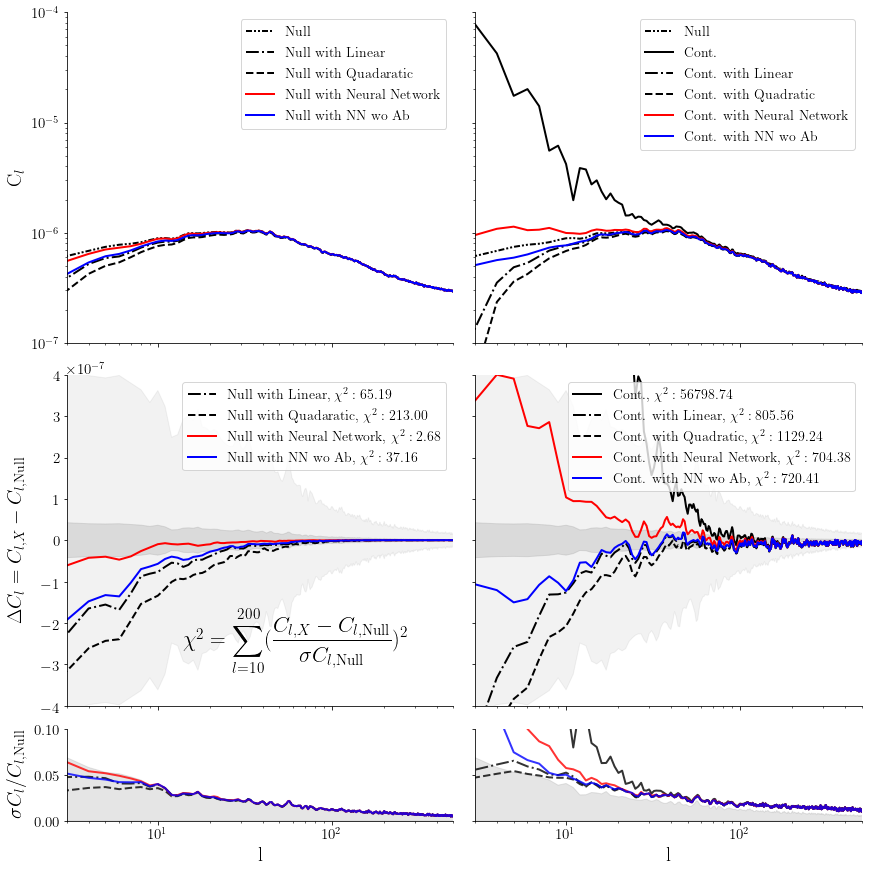

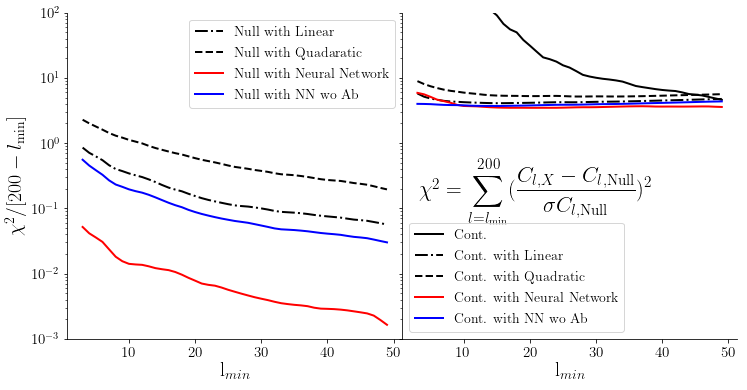

In [9]:
def plot_cl_auto_mocks():
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 20,
   #'text.fontsize': 8,
   'legend.fontsize': 14,
   'xtick.labelsize': 15,
   'ytick.labelsize': 15,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
   'font.size':15
   }
    plt.rcParams.update(params)    
    path = '/Volumes/TimeMachine/data/mocks/3dbox/'
    u_u = glob(path  + '*/results/clustering/cl_uni.npy')
    u_l = glob(path  + '*/results/clustering/cl_lin.npy')
    u_q = glob(path  + '*/results/clustering/cl_quad.npy')
    u_nb = glob(path + '*/results/clustering/cl_nn.npy')
    u_n = glob(path + '*/results/clustering/cl_nn_p}.npy')
    #
    c_u = glob(path  + '*/cp2p/results/clustering/cl_uni.npy')
    c_l = glob(path  + '*/cp2p/results/clustering/cl_lin.npy')
    c_la = glob(path  + '*/cp2p/results/clustering/cl_truth.npy')
    c_q = glob(path  + '*/cp2p/results/clustering/cl_quad.npy')
    c_nb = glob(path + '*/cp2p/results/clustering/cl_nn.npy')
    c_n = glob(path + '*/cp2p/results/clustering/cl_nn_p.npy')


    fus = [u_u, u_l, u_q, u_nb, u_n,
           c_u, c_l, c_q, c_nb, c_n]
    lb = ['Null', 'Null with Linear', 
          'Null with Quadaratic', 
          'Null with Neural Network',
          'Null with NN wo Ab',
          'Cont.', 'Cont. with Linear', 
          'Cont. with Quadratic', 
          'Cont. with Neural Network',
          'Cont. with NN wo Ab']#, 'Cont. with linear weights (truth)']#, 'Contaminated with linear (few maps)']
    #      'Contaminated with NN-Ablation weights']

    print(len(fus), len(lb))
    fig = plt.figure(constrained_layout=True, figsize=(12, 12))
    gs = GridSpec(ncols=2, nrows=5, figure=fig)
    gs.update(wspace=0.0, hspace=0.0) # like subplot adjust
    ax1 = fig.add_subplot(gs[:2, 0])
    ax2 = fig.add_subplot(gs[:2, 1])
    ax3 = fig.add_subplot(gs[2:4, 0])
    ax4 = fig.add_subplot(gs[2:4, 1])
    ax5 = fig.add_subplot(gs[4, 0])
    ax6 = fig.add_subplot(gs[4, 1])
    #fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

    c       = ['k', 'k', 'k', 'r','b',
               'k', 'k', 'k', 'r', 'b']
    ls      = [(0, (3, 1, 1, 1, 1, 1)), '-.','--', '-','-',
               '-', '-.','--', '-', '-']
    #ls      = 10*['-', '--', '-.', ':']
    nfls    = len(fus)-1
    cl_all  = dict()
    sigma   = dict()    
    nfiles  = len(fus[0])
    print(nfiles)
    for j,fij in enumerate(fus):
        cla = []
        for i in range(nfiles):
            fi = np.load(fij[i]).item()
            l  = np.arange(fi['auto'].size)
            cl = fi['auto']
            if j>4:
                cla.append(cl-3.4e-7)
            else:
                cla.append(cl)
        cl_all[lb[j]] = np.mean(np.array(cla), axis=0)
        sigma[lb[j]]  = np.std(np.array(cla), axis=0)/np.sqrt(len(cla))
    #    
    for a in [ax5, ax6]:
        a.fill_between(np.arange(sigma['Null'].size),0,
                     sigma['Null']/cl_all['Null'],  #*np.sqrt(nfiles)
                       color='grey', alpha=0.2, label=r'1$\sigma$ C.L. sample standard deviation')        
    
    for j, keyj in enumerate(cl_all.keys()):
        if keyj != 'Null':
            dcl  = (cl_all[keyj]-cl_all['Null'])
            chi2 = ((dcl[10:201]/sigma['Null'][10:201])**2).sum()
            s    = sigma[keyj]/cl_all['Null'] # divide by C_null            
            if 'Null' in keyj:
                ax1.plot(np.arange(cl_all[keyj].size), cl_all[keyj],
                    color=c[j], ls=ls[j], lw=2,
                    label=r'{:.50s}'.format(keyj))                
                ax3.plot(np.arange(cl_all[keyj].size), (dcl),
                    color=c[j], ls=ls[j], lw=2,
                    label=r'{:.50s}, $\chi^{}:{:5.2f}$'.format(keyj,2, chi2))
                ax5.plot(np.arange(cl_all[keyj].size), s, 
                                  color=c[j], alpha=0.8,lw=2,
                                   ls=ls[j])#label=r'{:.50s}'.format(keyj),
            else:
                ax2.plot(np.arange(cl_all[keyj].size), cl_all[keyj],
                    color=c[j], ls=ls[j], lw=2,
                    label=r'{:.50s}'.format(keyj))                
                ax4.plot(np.arange(cl_all[keyj].size), (dcl),#/cl_all['uncont.'], 
                    color=c[j], ls=ls[j], 
                    label=r'{:.50s}, $\chi^{}:{:5.2f}$'.format(keyj,2, chi2), lw=2)
                ax6.plot(np.arange(cl_all[keyj].size), s, 
                                  color=c[j], alpha=0.8, lw=2, 
                                  ls=ls[j])                # label=r'{:.50s}'.format(keyj),
        else:
            for a in [ax1, ax2]:
                a.plot(np.arange(cl_all[keyj].size), cl_all[keyj],
                    color=c[j], ls=ls[j], lw=2,
                    label=r'{:.50s}'.format(keyj))

    # ax.plot(lt, .2e6*clt, 'k-', label='theory')
    ax3.text(0.3, 0.1, r'$\chi^{2} = \displaystyle\sum_{l=10}^{200} (\frac{C_{l,X}-C_{l,{\rm Null}}}{\sigma C_{l,{\rm Null}}})^{2}$',
            transform=ax3.transAxes, fontsize=22)
    for a in [ax1, ax2]:
        a.set_xscale('log')
        a.set_yscale('log')
        xlim   = (3, 500)
        ylim   = (1.e-7, 1.e-4)
        a.set_xlim(*xlim)
        a.set_ylim(*ylim)
        a.legend(ncol=1)        
        
    for a in [ax3, ax4]:
        a.set_xscale('log')
        xlim   = (3, 500)
        ylim   = (-4.e-7, 4.e-7)
        a.set_xlim(*xlim)
        a.set_ylim(*ylim)
        a.legend(ncol=1, loc=1)        
        a.fill_between(np.arange(sigma['Null'].size), -sigma['Null'], 
                     sigma['Null'], color='grey', alpha=0.2)
        a.fill_between(np.arange(sigma['Null'].size), -sigma['Null']*np.sqrt(100.),
                     sigma['Null']*np.sqrt(100.), color='grey', alpha=0.1)
    ax1.set_ylabel(r'C$_{l}$')
    ax3.set_ylabel(r'$\Delta C_{l} = C_{l,X} - C_{l,{\rm Null}}$')#, fontsize=30)
    ax5.set_ylabel(r'$\sigma C_{l}/C_{l, {\rm Null}}$')#, fontsize=30)    
    for a in [ax5, ax6]:
        a.set_xscale('log')
        xlim   = (3, 500)
        ylim   = (0.0, 0.1)
        a.set_xlim(*xlim)
        a.set_ylim(*ylim)
        a.set_xlabel('l')  
    ax3.legend()
    for a in [ax1, ax2, ax3, ax4]:
        a.set_xticklabels([])
    for a in [ax2, ax4, ax6]:
        a.set_yticklabels([])
    fig.align_labels()
    plt.savefig('./figs/mocks_deltacl.pdf', bbox_inches='tight')
    #
    # CHI-square plot
    #
    #
    fig, ax = plt.subplots(ncols=2, figsize=(12,6), sharey=True)
    plt.subplots_adjust(wspace=0.0)
    #c  = plt.cm.brg
    #ls = 10*['-', '--', '-.', ':']
    nfls=len(fus)-1
    for j, keyj in enumerate(cl_all.keys()):
        if keyj != 'Null':
            dcl = (cl_all[keyj]-cl_all['Null'])
            chi2l = []
            lml = np.arange(3, 50)
            for m in lml:
                chi2   = np.sum((dcl[m:201]/sigma['Null'][m:201])**2)
                chi2l.append(chi2/(200-m))
            if 'Null' in keyj:
                ax[0].plot(lml, chi2l, color=c[j], ls=ls[j], 
                      label=r'{:.50s}'.format(keyj), lw=2)
            else:
                ax[1].plot(lml, chi2l, color=c[j], ls=ls[j], 
                      label=r'{:.50s}'.format(keyj), lw=2)


    ylim   = (1e-3, 1e2)
    for i,ai in enumerate(ax):
        #ai.fill_between(lml, 1, 30, color='grey', alpha=0.1)
        #ai.set_xscale('log')
        ai.set_yscale('log')
        ai.set_ylim(*ylim)
        ai.set_xlabel(r'l$_{min}$')
        ai.legend()#bbox_to_anchor=(0.0, 0.9, 1., .102))
    ax[1].text(0.05, 0.35, r'$\chi^{2} = \displaystyle\sum_{l=l_{{\rm min}}}^{200} (\frac{C_{l,X}-C_{l,{\rm Null}}}{\sigma C_{l,{\rm Null}}})^{2}$',
            transform=ax[1].transAxes, fontsize=22)    
    ax[0].set_ylabel(r'$\chi^{2}/[200-l_{{\rm min}}]$')#, fontsize=30)
    plt.savefig('./figs/mocks_deltacl_chi2.pdf', bbox_inches='tight')
plot_cl_auto_mocks()

ngal E(B-V)

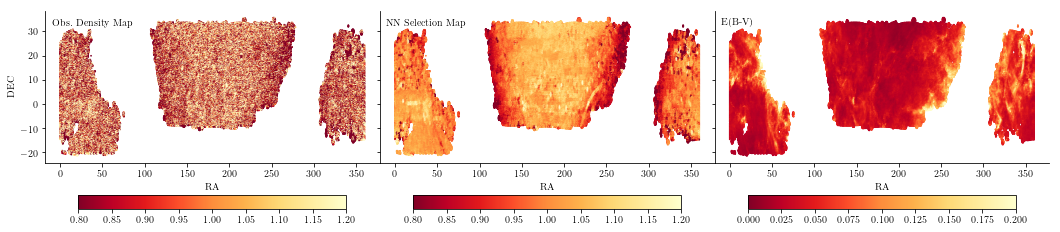

In [14]:
def ngal_ebv():    
    galmap = hp.read_map('/Volumes/TimeMachine/data/DR7/eboss-ngc-dr7.1.cut.hp256.fits', verbose=False)
    ebv = hp.read_map('/Volumes/TimeMachine/data/healSFD_256_fullsky.fits')
    wnn    = hp.read_map('/Volumes/TimeMachine/data/DR7/regression/nn/nn-r-ab-10/nn-weights.hp256.fits', verbose=False)
    wlin  = hp.read_map('/Volumes/TimeMachine/data/DR7/regression/mult-all/lin-weights.hp256.fits', verbose=False)
    wqud  = hp.read_map('/Volumes/TimeMachine/data/DR7/regression/mult-all/quad-weights.hp256.fits', verbose=False)
    mask  = hp.read_map('/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/mask.hp.fits', verbose=False).astype('bool')
    frac = hp.read_map('/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/fracgood.hp.fits', verbose=False)
    Wuni = galmap / frac *(frac[mask].sum()/galmap[mask].sum())
    Wnn  = wnn / np.mean(wnn[mask])
    Wlin = wlin / np.mean(wlin[mask])
    Wqud = wqud / np.mean(wqud[mask])
    plt.rc('axes.spines', top=False, right=False)
    plt.rc('font', family='serif')
    plt.rc('text', usetex=True)
    hpix = np.argwhere(mask).flatten()
    fig, ax = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)

    #ttl = ['No weights', 'Linear weights', 'NN weights']
    ttl = ['Obs. Density Map', 'NN Selection Map', 'E(B-V)']
    #for i,di in enumerate([duni, dlin, dnn]):
    for i,di in enumerate([Wuni, Wnn, ebv]):
        radec = hpix2radec(256, hpix)
        if i <2:
            vlims = (0.8, 1.2)
        else:
            vlims = (0.0, 0.2)
        map1 = ax[i].scatter(radec[0], radec[1], 0.5, 
                             #c=5*di[mask], vmin=-1, vmax=1.,
                            c=di[mask], vmin=vlims[0], vmax=vlims[1],
                            cmap=plt.cm.YlOrRd_r)
        fig.colorbar(map1, ax=ax[i], orientation='horizontal', shrink=0.8)
        ax[i].text(0.02, 0.9, ttl[i], transform=ax[i].transAxes)
        ax[i].set_xlabel('RA')
        ax[0].set_ylabel('DEC')
        #ax[i].axis([200, 310, 0, 20])
    # cax = plt.axes([.95, 0.1, 0.01, 0.8])
    #fig.colorbar(map1, cax=cax)
    #fig.colorbar(map1, cax=cax, label=r'$N/\overline{N}$')
    plt.savefig('./density_ebv.png', bbox_inches='tight', dpi=300)

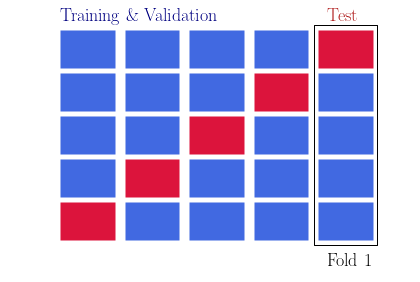

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
params = {'text.usetex': True, 'font.family':'serif', 'font.size':12}
plt.rcParams.update(params)
fig, ax = plt.subplots()
# create 3x3 grid to plot the artists

xw = 0.15
yw = 0.1
patches = []
colors  = []
ecolors = []
for i in range(5):
    for j in range(5):
        x = i*xw
        y = j*yw
        if i==j:
            colors.append('crimson')
        else:
            colors.append('royalblue')
        # add a rectangle
        rect  = Rectangle((x, y), 0.85*xw, 0.9*yw)
        patches.append(rect)
        ecolors.append('None')

i = 4
j = 0
x = i*xw
y = j*yw        
patches.append(Rectangle((x-0.01, y-0.01), 0.98*xw, 5.1*yw, fill=False))
colors.append('None')
ecolors.append('k')
collection = PatchCollection(patches, facecolor=colors, edgecolors=ecolors)
ax.add_collection(collection)

ax.text(0, 0.51, 'Training \& Validation', fontsize=18, color='navy')
ax.text(0.62, 0.51, 'Test', fontsize=18,   color='firebrick')
ax.text(0.62, -0.06, 'Fold 1', fontsize=18, color='k')
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.savefig('./figs/5folds.pdf', bbox_inches='tight')

Error bar on DR7 C_l

In [15]:
cldr7 = np.load('/Volumes/TimeMachine/data/DR7/results/clustering/cl_uni.npy').item()
cla   = cldr7['auto']
clerr = cldr7['clerr']['clerr']
sf    = 0.228365
el    = np.arange(513)
clmc  = cla / np.sqrt(0.5* (2*el+1) * sf)

Text(0.5,0,'ell')

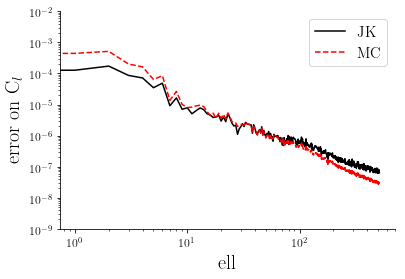

In [24]:
plt.plot(el, clerr, 'k-',label='JK')
plt.plot(el, clmc, 'r--', label='MC')
plt.loglog()
plt.legend()
plt.ylim(1.e-9, 1.e-2)
plt.ylabel(r'error on C$_l$')
plt.xlabel('ell')

In [27]:
clall = []
for i in range(20):
    clall.append(cldr7['clerr']['cljks'][i])
clall = np.array(clall)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, -1])

Text(0.5,0,'ell')

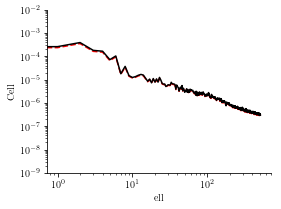

In [58]:
plt.plot(el, np.mean(clall, axis=0), 'r--')
# for i in range(20):
#     plt.plot(el, cla-clall[i, :], 'r--', alpha=0.1)
plt.plot(el, cla, 'k-')
plt.yscale('log')
plt.ylim(1.e-9, 1.e-2)
plt.xscale('log')
plt.ylabel('Cell')
plt.xlabel('ell')

Text(200,0.05,'$\\frac{mean(C^{{\\rm Jacks}})}{C^{simple}}-1$')

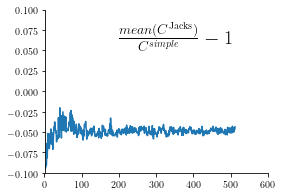

In [56]:
# plt.plot(el, cla)
plt.plot(el, np.mean(clall, axis=0)/ cla - 1.)
plt.ylim(-0.1, 0.1)
plt.xlim(1, 600)
plt.text(200, 0.05, r'$\frac{mean(C^{{\rm Jacks}})}{C^{simple}}-1$', fontsize=20)

## NNbar vs. systematics for the mocks

In [8]:
nfu = glob('/Volumes/TimeMachine/data/mocks/3dbox/*/results/clustering/nnbar_uni.npy')
nfs = glob('/Volumes/TimeMachine/data/mocks/3dbox/*/cp2p/results/clustering/nnbar_uni.npy')
nfr = glob('/Volumes/TimeMachine/data/mocks/3dbox/*/cp2p/results/clustering/nnbar_nn.npy')
nfl = glob('/Volumes/TimeMachine/data/mocks/3dbox/*/cp2p/results/clustering/nnbar_lin.npy')
nfq = glob('/Volumes/TimeMachine/data/mocks/3dbox/*/cp2p/results/clustering/nnbar_quad.npy')

In [6]:
len(nfs), len(nfr)

(100, 100)

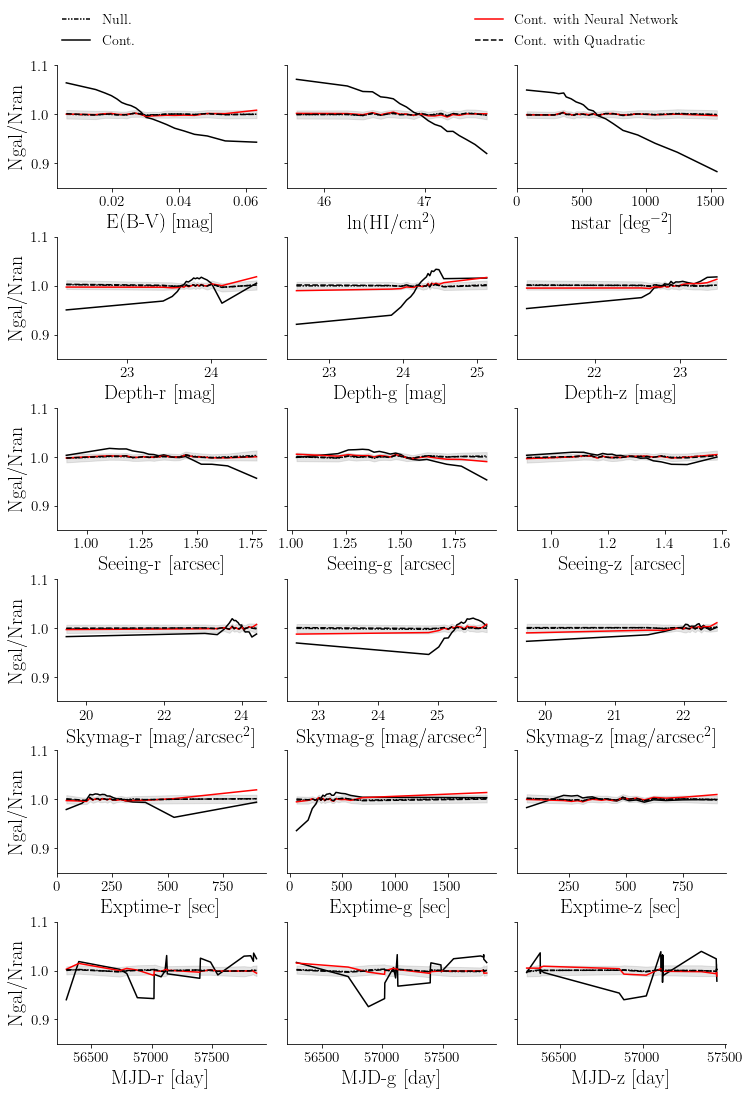

In [9]:
params = {
'axes.spines.right':False,
'axes.spines.top':False,
'axes.labelsize': 20,
#'text.fontsize': 8,
'legend.fontsize': 14,
'xtick.labelsize': 15,
'ytick.labelsize': 15,
'text.usetex': True,
#'figure.figsize': [4, 3],
'font.family':'serif',
'font.size':15
}
plt.rcParams.update(params)    
fig, ax = plt.subplots(ncols=3, nrows=6, sharey=True, figsize=(12, 18)) # 10, 16.5
plt.subplots_adjust(wspace=0.1, hspace=0.4)
ax = ax.flatten()


def addplot(nfs, label, fill, **kw):
    for j in range(18):
        ym = []        
        for i, nfi in enumerate(nfs):
            nfd = np.load(nfi).item()
            nd  = nfd['nnbar'][j]
            x   = nd['bin_edges'][:-1]
            y   = nd['nnbar']
#             if i%10==0:ax[j].plot(x, y, **kw)
            ym.append(y)
        Ym = np.mean(np.array(ym), axis=0)
        Ys = np.std(np.array(ym), axis=0, ddof=1)
        #print(Ys)
        ax[j].plot(x, Ym, color=kw['color'], ls=kw['ls'], label=label)
        #ax[j].axhline(1.0, color='k', ls=':')
        if fill:
            ax[j].fill_between(x, Ym-Ys, Ym+Ys, color=kw['color'], alpha=kw['alpha'])
            #ax[j].errorbar(x[0], 1.0, Ys[0], color=kw['color'])
    #print('======')
xlabels = ['E(B-V) [mag]', r'ln(HI/cm$^{2}$)', r'nstar [deg$^{-2}$]']\
         + ['Depth-'+b+' [mag]' for b in 'rgz'] \
         + ['Seeing-'+b+' [arcsec]' for b in 'rgz'] \
         + [r'Skymag-'+b+' [mag/arcsec$^{2}$]' for b in 'rgz'] \
         + ['Exptime-'+b+' [sec]' for b in 'rgz'] \
         + ['MJD-'+b+' [day]' for b in 'rgz']  

addplot(nfu, 'Null.', True,  color='k', ls=(0, (3, 1, 1, 1, 1, 1)), alpha=0.1)
addplot(nfs, 'Cont.', False, color='k', ls='-', alpha=0.1)
addplot(nfr, 'Cont. with Neural Network', False, color='r', ls='-', alpha=0.1)
addplot(nfq, 'Cont. with Quadratic', False, color='k', ls='--', alpha=0.1)

lgnarg = dict(ncol=2, frameon=False,
             bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
            mode="expand", borderaxespad=0)
ax[0].legend(**lgnarg)
for j in range(18):
    ax[j].set_xlabel(xlabels[j])
    if j % 3 ==0:ax[j].set_ylabel('Ngal/Nran')
ax[0].set_ylim(0.85, 1.1)
plt.savefig('./figs/nnbar_mocks.pdf', bbox_inches='tight')

In [ ]:
def plot_nnbar(config):
    params = {
   'axes.spines.right':False,
   'axes.spines.top':False,
   'axes.labelsize': 15,
   #'text.fontsize': 8,
   'legend.fontsize': 15,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': True,
   #'figure.figsize': [4, 3],
   'font.family':'serif',
    'font.size':12
   }    
    xlabels = ['E(B-V) [mag]', r'ln(HI/cm$^{2}$)', r'nstar [deg$^{-2}$]']\
             + ['Depth-'+b+' [mag]' for b in 'rgz'] \
             + ['Seeing-'+b+' [arcsec]' for b in 'rgz'] \
             + [r'Skymag-'+b+' [mag/arcsec$^{2}$]' for b in 'rgz'] \
             + ['Exptime-'+b+' [sec]' for b in 'rgz'] \
             + ['MJD-'+b+' [day]' for b in 'rgz']    
    plt.rcParams.update(params)    
    lgnarg = dict(ncol=2,frameon=False,
                 bbox_to_anchor=(0, 1.1, 3, 0.4), loc="lower left",
                mode="expand", borderaxespad=0)    
    def chi2 (x, y, ye): 
        dx = np.diff(x)[2]
        m = (~np.isnan(y)) & (~np.isnan(ye) & (ye != 0.0))
        terms = (y[m]-1.0)/ye[m]
        worst = x[m][np.argmax(terms)]
        return np.sum(terms**2), m.sum()
    c  = ['k', 'k', 'k', 'r']    
    ls = ['-','-.','--', '-']
    Nd = len(config['nnbarplot']['flb'])
    fig, ax = plt.subplots(ncols=3, nrows=6, sharey=True, figsize=(12, 18)) # 10, 16.5
    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    ax = ax.flatten()
    #fig.delaxes(ax[-1])
    def add_ax(ax, res, shift=1.0, step=True, **kw):
        m = (~ np.isnan(res['nnbar'])) & (res['nnbar_err']!=0.0)
        if step:
            ax.errorbar(res['bin_edges'][:-1][m]*shift, res['nnbar'][m],
                     yerr=res['nnbar_err'][m], **kw)
        else:
            ax.plot(res['bin_edges'][:-1][m]*shift, res['nnbar'][m], **kw)        
        ax.axhline(1, linestyle=':', color='k')
        #if step:ax.fill_between(res['bin_edges'][:-1][m], 1-res['nnbar_err'][m], 1+res['nnbar_err'][m], color='grey')
#         ax2 = ax.twinx()
#         ax2.set_yticks([])
        #ax2.set_ylim(0, 600)
#         if step:ax2.step(res['bin_edges'][:-1][m], res['area'][m], where='post',
#                          linestyle=':', color='grey', alpha=0.3)
    CHIS = np.zeros(Nd)
    DOFS = np.zeros(Nd)
    for i,df in enumerate(config['nnbarplot']['flb']):
        di = np.load(config['nnbarplot']['nnbarpath'](df)).item()
        for j in range(len(di['xlabels'])):
            if i ==0:
                step=True
            else:
                step=False
            add_ax(ax[j], di['nnbar'][j], color=c[i], ls=ls[i], label=config['nnbarplot']['lb'][i], step=step)
            ci2, dof = chi2(di['nnbar'][j]['bin_edges'][:-1], di['nnbar'][j]['nnbar'], di['nnbar'][j]['nnbar_err'])
            CHIS[i] += ci2
            DOFS[i] += dof
            if i==0:
                if j%3 == 0:ax[j].set_ylabel(r'N/$\overline{N}$')
                #ax[j].set_xlabel(di['xlabels'][j])
                ax[j].set_xlabel(xlabels[j])
                ax[j].set_ylim(0.8, 1.2)
                ax[j].locator_params(tight=True, nbins=5)
        #if i ==1:ax[i].set_xlim(xmax=6000)
    ax[0].legend(**lgnarg)
    print(config['nnbarplot']['flb'])
    print(CHIS)
    print(DOFS)
    print(CHIS/DOFS)
    #plt.savefig('./figs/nnbar_dr7.pdf', bbox_inches='tight')
plot_nnbar(config)